# Простейшие нейронные сети на PyTorch


Фрэймворком для обучения нейросеток на нашем курсе будет PyTorch. PyTorch стал очень популярным благодаря интуитивно понятной парадигме программирования нейронных сетей, основанной на динамическом графе. Не так давно PyTorch создал свою экосистему https://pytorch.org/ecosystem/, которая содержит в себе библиотеки, решающие практически всевозможные задачи машинного обучения. 

Чтобы установить библиотеку PyTorch, отправляйтесь в консоль и пропишите 

```
Для Windows без GPU
pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Для Windows c GPU
pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Для Linux без GPU
pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Для Linux c GPU
pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Для Mac
pip install torch torchvision

pip install pytorch-lightning
```


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
# Подгружаем pytorch 
import torch

print(torch.__version__)

1.6.0


In [82]:
# Подгрузим ещё немного пакетов :) 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

%matplotlib inline

## 1. О данных и бэйзлайнах

Наша главная цель - познакомиться с процессом создания простой нейронной сети и ее обучения.

__Делать всё это мы будем на животных.__ Ежегодно около 7.6 миллионов бедных животных в США оказываются в приютах. Часть из них находит себе новую семью, часть возвращается к старому (бывает, что питомец потерялся и его нашли на улице), а часть погибает. Ужегодно усыпляется около 2.7 млн. собак и кошек.  

Используя датасет с входной информацией (цвет, пол, возраст и т.п.) из одного из приютов, мы попытаемся спрогнозировать что произойдёт с новыми животными, которые попадут в этот приют. Данные, используемые в тетрадке уже были предварительно обработаны и приведены в удобную для построения моделей форму. 

In [131]:
X = pd.read_csv('X_cat.csv', sep = '\t', index_col=0)
target = pd.read_csv('y_cat.csv', sep = '\t', index_col=0, names=['status'])

print(X.shape)
X.head()

(26729, 37)


,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,...,1,0,0,0,0,0,0,0,0,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,...,0,1,0,0,0,0,0,1,0,0
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,...,1,0,0,0,0,0,0,1,0,0


В датасете находится около 27 тысяч наблюдений и 39 регрессоров. Посмотрим на то как выглядит распределение того, что произошло со зверятами по особям.

In [132]:
target.status.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: status, dtype: int64

Видим, что классы несбалансированы. Попробуем оставит четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [133]:
target = target.iloc[:, :]
target[target == 'Died'] = 'Euthanasia'

Закодируем классы.

In [134]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target)
y

/home/firiuza/anaconda2/envs/pytorch_env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([2, 1, 0, ..., 0, 3, 3])

In [135]:
len(y)

26729

In [136]:
X.shape

(26729, 37)

Разобьём выборку на тренировочную и тестовую. 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(21383, 37)
(5346, 37)


Прежде, чем учить 228-слойных монстров, давайте построим какие-нибудь простые прогнозы, чтобы было с чем сравнить. Давайте построи наивный прогноз, а также обучим линейную регрессию и случайный лес.

### Константный прогноз

Построим константный прогноз, чтобы было с чем сравнивать и прогноз по какой-нибудь модели. 

In [11]:
from sklearn.metrics import log_loss

probas = np.array(pd.Series(y_train).value_counts(normalize=True).sort_index().tolist())
probas

array([0.40289015, 0.0655661 , 0.17906748, 0.35247627])

In [12]:
log_loss(y_test, np.tile(probas, X_test.shape[0]).reshape(X_test.shape[0], 4))

1.2202552496487795

### Логистическая регрессия

In [13]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression( )
logreg.fit(X_train, y_train)
log_loss(y_test, logreg.predict_proba(X_test))

1.0690584393593154

In [14]:
logreg.predict_proba(X_test) # 4 колонки, по одной на каждый класс

array([[0.18708684, 0.06705243, 0.04653593, 0.6993248 ],
       [0.71548707, 0.02923266, 0.10843193, 0.14684834],
       [0.52376056, 0.03809807, 0.18069067, 0.2574507 ],
       ...,
       [0.7750991 , 0.01024906, 0.17602374, 0.0386281 ],
       [0.22847272, 0.05774069, 0.03826552, 0.67552107],
       [0.66540976, 0.03012005, 0.1208279 , 0.18364229]])

### Случайный лес 

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, n_jobs=3)
rf.fit(X_train, y_train)
log_loss(y_test, rf.predict_proba(X_test))

0.7614843903643865

Неплохой результат. Попробуем улучшить его с помошью нейросеток. 

## 2. Собираем свою нейросеть

In [108]:
INPUT_SIZE = 37
HIDDEN_SIZE = 25
OUTPUT_SIZE = 4
LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 128

# FAST.AI

In [11]:
from fastai.tabular.all import *

Загрузим датасет, где необходимо предсказать, будет ли человек зарабатывать больше $50K в год.

In [46]:
path = untar_data(URLs.ADULT_SAMPLE)
path.ls()

(#3) [Path('/home/firiuza/.fastai/data/adult_sample/export.pkl'),Path('/home/firiuza/.fastai/data/adult_sample/adult.csv'),Path('/home/firiuza/.fastai/data/adult_sample/models')]

In [47]:
df = pd.read_csv(path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [48]:
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

In [49]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [69]:
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                   cont_names = ['age', 'fnlwgt', 'education-num'],
                   y_names='salary',
                   splits=splits)

In [70]:
dls = to.dataloaders(bs=BATCH_SIZE)

In [71]:
learn = tabular_learner(dls, metrics=accuracy)

In [72]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.369988,0.357349,0.838145,00:03
1,0.349478,0.350613,0.839066,00:03


In [62]:
learn.show_results()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary,salary_pred
0,5.0,16.0,1.0,5.0,2.0,5.0,1.0,57.0,175942.0,10.0,1.0,0.0
1,5.0,16.0,3.0,4.0,1.0,5.0,1.0,51.0,145409.0,10.0,1.0,0.0
2,5.0,16.0,3.0,4.0,1.0,5.0,1.0,61.0,231323.0,10.0,0.0,0.0
3,5.0,16.0,5.0,2.0,5.0,4.0,1.0,25.0,123586.0,10.0,0.0,0.0
4,5.0,3.0,5.0,9.0,2.0,4.0,1.0,53.0,48641.0,8.0,0.0,0.0
5,7.0,1.0,6.0,8.0,2.0,5.0,1.0,38.0,115215.0,6.0,0.0,0.0
6,7.0,15.0,3.0,11.0,1.0,5.0,1.0,39.0,218490.0,15.0,1.0,1.0
7,5.0,16.0,5.0,13.0,4.0,5.0,1.0,20.0,271379.0,10.0,0.0,0.0
8,5.0,1.0,3.0,7.0,1.0,5.0,1.0,43.0,156403.0,6.0,0.0,0.0


In [73]:
row, clas, probs = learn.predict(df.iloc[0])

In [74]:
row.show()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,Assoc-acdm,Married-civ-spouse,#na#,Wife,White,False,49.0,101320.0,12.0,>=50k


# Vanilla PyTorch

Код прдеставленный выше от fastai значительно упрощает работу с нейронными сетями, но не дает понять, что же происходит на самом деле. Поэтомуна первых порах лучше все писать самим. Для этого обратимся к первоисточнику, а именно к оригинальному PyTorch, с которого все началось. И для начала разберем все этапы работы с нейронной сети в упрощенной форме. 

In [77]:
import torch.nn as nn # содержит функции для реалзации архитектуры нейронных сетей
import torch.nn.functional as F # содержит различные функции активации и не только
import torch.optim as optim
import torch.utils.data as data_utils

from pytorch_lightning.metrics import Accuracy


Архитектуру нейронной сети в PyTorch можно описать нескольками способами, в дальнейшем мы рассмотрим их более подробно. Сейчас предлагается сделать это используя `Sequential`.
`Sequential` -- это последовательный способ объявления каждой компоненты архитектуры нейронной сети.

In [78]:
def build_model():
    model = nn.Sequential(  
        # Добавляем в нашу модель первый слой из 25 нейронов
        nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE),
        nn.Sigmoid(),
        
        # Добавляем ещё один слой из 25 нейронов
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.Sigmoid(),
        
        # Выходной вектор на количество классов, получаем с помощью такого же линейного приеобразования,
        # как и предыдущие слои, но уже на нужное количество выходных нейронов (т.е. классов)
        nn.Linear(in_features=HIDDEN_SIZE, out_features=OUTPUT_SIZE),
        nn.Softmax()
    )

    return model

Перед тем как обучать нашу нейросеть, нужно задать параметры обучения. Во-первых, метод оптимизации. Во-вторых, функцию потерь. В-третьих, парочку метрик, на которые нам хотелось бы смотреть в процессе обучения.  

In [79]:
model = build_model()

Итак, только что мы собрали свою первую нейросеть со скрытым слоем.

In [80]:
print(model)

Sequential(
  (0): Linear(in_features=37, out_features=25, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=25, out_features=4, bias=True)
  (5): Softmax(dim=None)
)


Для того чтобы подавать данные в нейронную сеть, создадим `DataLoader`, который предоставляет гибкий API для работы с входными данными.

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, stratify=y, random_state=42)

In [143]:
def create_data_loader(X_train, y_train, X_test, y_test):
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=BATCH_SIZE,
                                         shuffle=True)
    return train_loader, test_loader

In [85]:
train_loader, test_loader = create_data_loader(X_train, y_train, X_test, y_test)

Отлично! Модель собрана и данный загружены. Осталось ее обучить. Для этого нужно указать целевую функцию и оптимизатор, который позволит обновлять веса. Так же в процессе обучения будем отслеживать изменения текущей точности модели.

In [86]:
criterion = nn.CrossEntropyLoss()
accuracy = Accuracy()

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

Создадим массивы, куда будем складывать значение целевой функции на обучающей и валиационной выборках, а также точность.

Ниже представлен код обучения сети. Нужно обратить внимание на несколько моментов:
1. Обучение ведется в течение нескольких эпох -- что значит несколько проходов по выборке.
2. `train_loader` позволяет итеративно проходится по выборке и на каждой итерации получать батч заранее заданного размера.
3. На каждом шаге обнуляем градиенты `optimizer.zero_grad()`, чтобы не накапливать их, тем самым неккоректно обновлять веса.
4. Вызывать явно `loss.backward()` для вычисления градиентов.
5. Вызывать явно `optimizer.step()` для обновления весов.

In [141]:
step = 0
train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy = []

def run_train():
    step = 0
    for epoch in range(EPOCHS):
        running_loss = []
        running_acc = []
        for features, label in train_loader:
            # Reset gradients
            optimizer.zero_grad()

            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label)
            loss.backward()
            acc = accuracy(output, label).item()

            # Update weights with gradients
            optimizer.step()

            running_loss.append(loss.item())
            running_acc.append(acc)

            step += 1

        train_loss_values.append(np.mean(running_loss))
        train_accuracy_values.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d : train_loss: %f train_acc: %f' % (epoch, train_loss_values[-1], train_accuracy_values[-1]))


        # Run validation
        running_loss = []
        running_acc = []
        for features, label in test_loader:
            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label)
            acc = accuracy(output, label).item()

            running_loss.append(loss.item())
            running_acc.append(acc)

        valid_loss_values.append(np.mean(running_loss))
        valid_accuracy.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d : valid_loss: %f valid_acc: %f' % (epoch, valid_loss_values[-1], valid_accuracy[-1]))
        
    return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy

In [93]:
train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy = run_train()

EPOCH 0 : train_loss: 1.288489 train_acc: 0.400623
EPOCH 0 : valid_loss: 1.287542 valid_acc: 0.403118
EPOCH 20 : train_loss: 1.288096 train_acc: 0.403035
EPOCH 20 : valid_loss: 1.287990 valid_acc: 0.402492
EPOCH 40 : train_loss: 1.288530 train_acc: 0.402231
EPOCH 40 : valid_loss: 1.287812 valid_acc: 0.402720
EPOCH 60 : train_loss: 1.287843 train_acc: 0.402231
EPOCH 60 : valid_loss: 1.287887 valid_acc: 0.402720
EPOCH 80 : train_loss: 1.287812 train_acc: 0.402231
EPOCH 80 : valid_loss: 1.287723 valid_acc: 0.403175


 Посмотрим на динамику ошибки и значение точности нашей модели во времени.

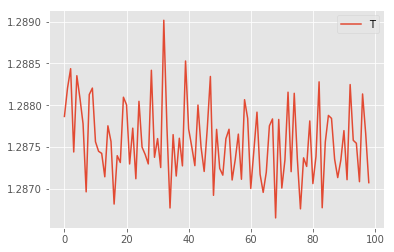

In [94]:
start = 1
plt.plot(train_loss_values[start:])
plt.legend('Train loss')

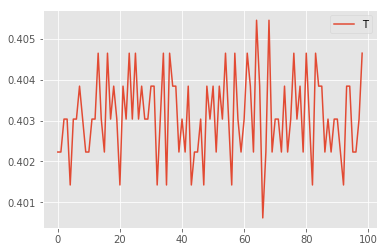

In [95]:
start = 1
plt.plot(train_accuracy_values[start:])
plt.legend('Train accuracy')

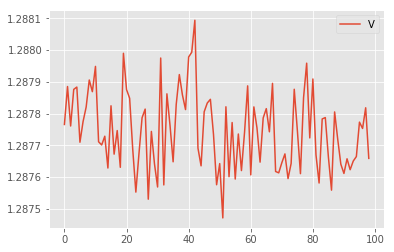

In [96]:
plt.plot(valid_loss_values[start:])
plt.legend('Validation loss')

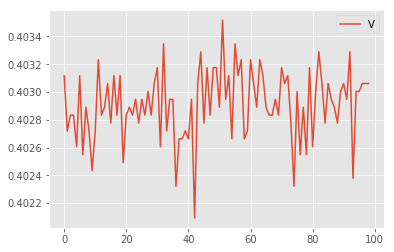

In [97]:
plt.plot(valid_accuracy[start:])
plt.legend('Validation accuracy')

Сохраним модель. Файл может иметь два расширения, как .pt, так и .pth. 

In [98]:
torch.save(model, 'simple_nn.pth')

Теперь загрузим сохраненную модель и посмотрим на ее предсказания. Важно! Когда идет этап inference модели, то нужно явно вызвать `model.eval()`, так как в случае если есть droupout или batch norm, то они не дложны работать как в процессе обучения, иначе они продолжат обучаться. 

In [99]:
model = torch.load('simple_nn.pth')
model.eval()

Sequential(
  (0): Linear(in_features=37, out_features=25, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=25, out_features=4, bias=True)
  (5): Softmax(dim=None)
)

In [100]:
# Выход модели (вероятность) на тестовой выборке
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.astype(np.float32)))
print(accuracy(test_scores, torch.tensor(y_test.astype(np.int))).item())
print(test_scores.numpy())

0.4029180705547333
[[5.8077049e-01 4.8781681e-04 1.3908893e-03 4.1735077e-01]
 [5.8077049e-01 4.8781681e-04 1.3908893e-03 4.1735077e-01]
 [5.8077049e-01 4.8781681e-04 1.3908893e-03 4.1735077e-01]
 ...
 [5.8077061e-01 4.8781716e-04 1.3908902e-03 4.1735065e-01]
 [5.8077049e-01 4.8781681e-04 1.3908893e-03 4.1735077e-01]
 [5.8077049e-01 4.8781704e-04 1.3908906e-03 4.1735086e-01]]


In [101]:
# Предсказание классов на тестовой выборке
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.astype(np.float32)))
predicted_classes = torch.argmax(test_scores, dim=1)
print(predicted_classes)

tensor([0, 0, 0,  ..., 0, 0, 0])


Модель сходится плохо. Точность не растет. __Как думаете, с чем это связано?__

__Ответ:__ Вспомним про такую замечательную штуку как нормальзация и посмотрим насколько она улучшит скорость обучения и качество модели.

In [138]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Обучаем модель на нормализованных данных. Попробуем учить подольше. Так сказать: двойной удар по сходимости. 

In [144]:
train_loader, test_loader = create_data_loader(X_train, y_train, X_test, y_test)

model = build_model()

In [145]:
EPOCHS = 200

train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy = run_train()

/home/firiuza/anaconda2/envs/pytorch_env/lib/python3.6/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


EPOCH 0 : train_loss: 1.389828 train_acc: 0.402231
EPOCH 0 : valid_loss: 1.389636 valid_acc: 0.402663
EPOCH 20 : train_loss: 1.389787 train_acc: 0.403035
EPOCH 20 : valid_loss: 1.389640 valid_acc: 0.403175
EPOCH 40 : train_loss: 1.389700 train_acc: 0.402231
EPOCH 40 : valid_loss: 1.389667 valid_acc: 0.402777
EPOCH 60 : train_loss: 1.389851 train_acc: 0.401427
EPOCH 60 : valid_loss: 1.389652 valid_acc: 0.402833
EPOCH 80 : train_loss: 1.389570 train_acc: 0.403838
EPOCH 80 : valid_loss: 1.389622 valid_acc: 0.403346
EPOCH 100 : train_loss: 1.389502 train_acc: 0.403838
EPOCH 100 : valid_loss: 1.389579 valid_acc: 0.403289
EPOCH 120 : train_loss: 1.389750 train_acc: 0.401427
EPOCH 120 : valid_loss: 1.389650 valid_acc: 0.402720
EPOCH 140 : train_loss: 1.389616 train_acc: 0.403035
EPOCH 140 : valid_loss: 1.389674 valid_acc: 0.402890
EPOCH 160 : train_loss: 1.389768 train_acc: 0.402231
EPOCH 160 : valid_loss: 1.389656 valid_acc: 0.403004
EPOCH 180 : train_loss: 1.389701 train_acc: 0.402231
EPOCH

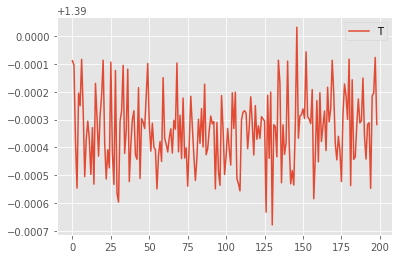

In [146]:
start = 1
plt.plot(train_loss_values[start:])
plt.legend('Train loss')

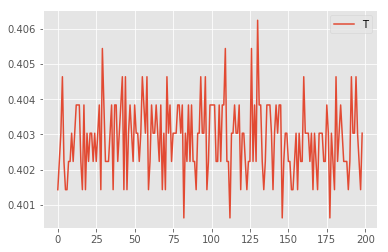

In [147]:
start = 1
plt.plot(train_accuracy_values[start:])
plt.legend('Train accuracy')

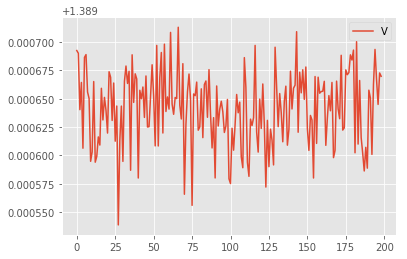

In [148]:
plt.plot(valid_loss_values[start:])
plt.legend('Validation loss')

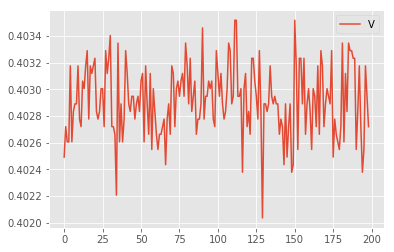

In [149]:
plt.plot(valid_accuracy[start:])
plt.legend('Validation accuracy')